In [23]:
import numpy as np
import matplotlib.pyplot as plt

In [24]:
data = np.load('outputs/adamw_corrupted/losses.npy')
true_labels = np.load('outputs/adamw_corrupted/true_labels.npy')
corrupted_labels = np.load('outputs/adamw_corrupted/corrupted_labels.npy')

In [25]:
is_corrupted = true_labels != corrupted_labels
is_corrupted.sum().item()

5115

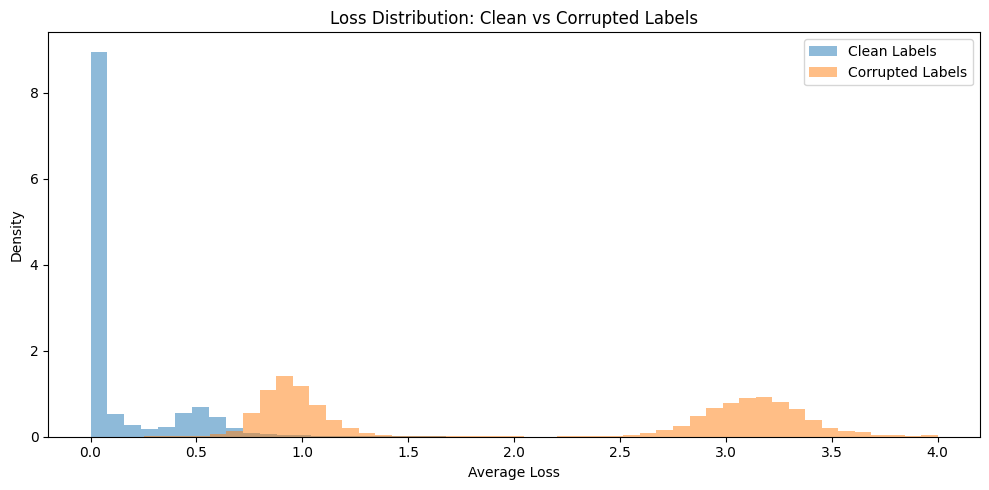

In [29]:
avg_loss = np.clip(data, 0, 4).mean(axis=0)

plt.figure(figsize=(10, 5))

plt.hist(avg_loss[~is_corrupted], bins=50, alpha=0.5, label='Clean Labels', density=True)
plt.hist(avg_loss[is_corrupted], bins=50, alpha=0.5, label='Corrupted Labels', density=True)
plt.xlabel('Average Loss')
plt.ylabel('Density')
plt.title('Loss Distribution: Clean vs Corrupted Labels')
plt.legend()

plt.tight_layout()
plt.savefig('loss_analysis.png')
plt.show()

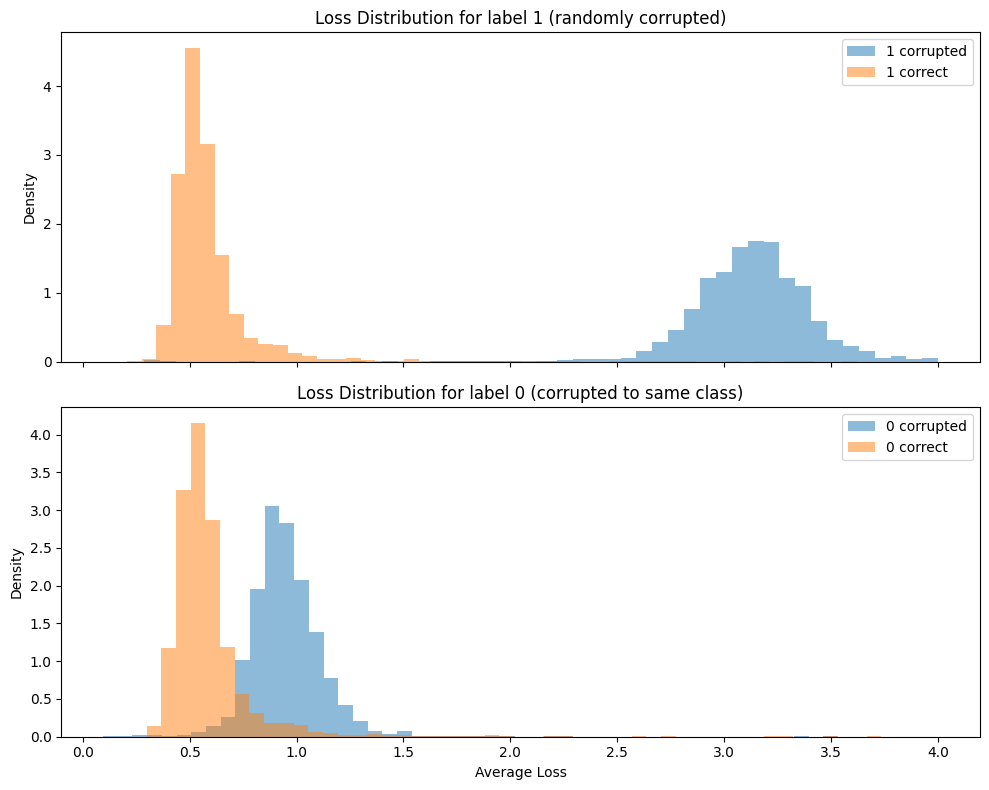

In [71]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8), sharex=True)

axes[0].hist(avg_loss[(true_labels == 1) & is_corrupted], bins=50, alpha=0.5, label='1 corrupted', density=True)
axes[0].hist(avg_loss[(true_labels == 1) & (~is_corrupted)], bins=50, alpha=0.5, label='1 correct', density=True)
axes[0].set_title('Loss Distribution for label 1 (randomly corrupted)')
axes[0].set_ylabel('Density')
axes[0].legend()

axes[1].hist(avg_loss[(true_labels == 0) & is_corrupted], bins=50, alpha=0.5, label='0 corrupted', density=True)
axes[1].hist(avg_loss[(true_labels == 0) & (~is_corrupted)], bins=50, alpha=0.5, label='0 correct', density=True)
axes[1].set_title('Loss Distribution for label 0 (corrupted to same class)')
axes[1].set_xlabel('Average Loss')
axes[1].set_ylabel('Density')
axes[1].legend()

plt.tight_layout()
plt.savefig('loss_analysis.png')
plt.show()
